In [42]:
import pandas as pd
import re
import spacy
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Cargar modelo spaCy
nlp = spacy.load("es_core_news_sm")
modelo = ["GPT-4o-mini", "llama-3.1-8b-instant", "llama-3.3-70b-versatile", "gemma2-9b-it"]

# Cargar datos
df = pd.read_excel("../datos/Clasificación_llama-3.3-70b-versatile-Completo.xlsx")
texts = df["Raw_llama-3.3-70b-versatile_Chain_Of_Thought"].dropna().astype(str).tolist()
polaridad = df["Polarity_llama-3.3-70b-versatile_Chain_Of_Thought"].dropna().astype(str).tolist()
polaridad_True = df["Polarity"].dropna().astype(str).tolist()

In [43]:
def traducir_emojis(texto):
    texto = emoji.demojize(texto, language="es")
    texto = texto.replace(":", " ").replace("_", " ")
    return texto

def limpiar_y_lematizar(texto):
    texto = texto.lower()  # minúsculas
    texto = traducir_emojis(texto)  # traducir emojis
    texto = re.sub(r"Texto:.*?2\. interpretación del tono general[:]*", '', texto, flags=re.IGNORECASE | re.DOTALL)
    texto = re.sub(r"detección de matices[:]*", '', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)  # quitar URLs
    texto = re.sub(r"@\w+", '', texto)  # quitar menciones
    texto = re.sub(r"#\w+", '', texto)  # quitar hashtags
    texto = re.sub(r"[^\w\sáéíóúüñ]", '', texto)  # quitar signos raros y puntuación
    doc = nlp(texto)  # procesar con spaCy para lematizar
    lemas = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(lemas)

texts_procesados = [limpiar_y_lematizar(t) for t in texts]

In [44]:
df_polaridad = pd.DataFrame({  ## Crear DataFrame con polaridad y textos procesados
    "texto": texts_procesados,
    "polaridad": polaridad
})

df_polaridad_true = pd.DataFrame({  ## Crear DataFrame con polaridad verdadera y textos procesados
    "texto": texts_procesados,
    "polaridad": polaridad_True
})

grupos = df_polaridad.groupby("polaridad")["texto"].apply(lambda x: " ".join(x))
grupos_true = df_polaridad_true.groupby("polaridad")["texto"].apply(lambda x: " ".join(x))


In [45]:
vectorizer = CountVectorizer(max_features=30)
vectorizer_tfidf = TfidfVectorizer(max_features=30)
vectorizer_pol = TfidfVectorizer(max_features=30)


Xbow = vectorizer.fit_transform(texts_procesados)
Xtfidf = vectorizer_tfidf.fit_transform(texts_procesados)
X_polaridades = vectorizer_pol.fit_transform(grupos)
X_polaridades_true = vectorizer_pol.fit_transform(grupos_true)

df_bow = pd.DataFrame(Xbow.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf = pd.DataFrame(Xtfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())
df_tfidf_polar = pd.DataFrame(X_polaridades.toarray(), index=grupos.index, columns=vectorizer_pol.get_feature_names_out())
df_tfidf_polar_true = pd.DataFrame(X_polaridades_true.toarray(), index=grupos_true.index, columns=vectorizer_pol.get_feature_names_out())

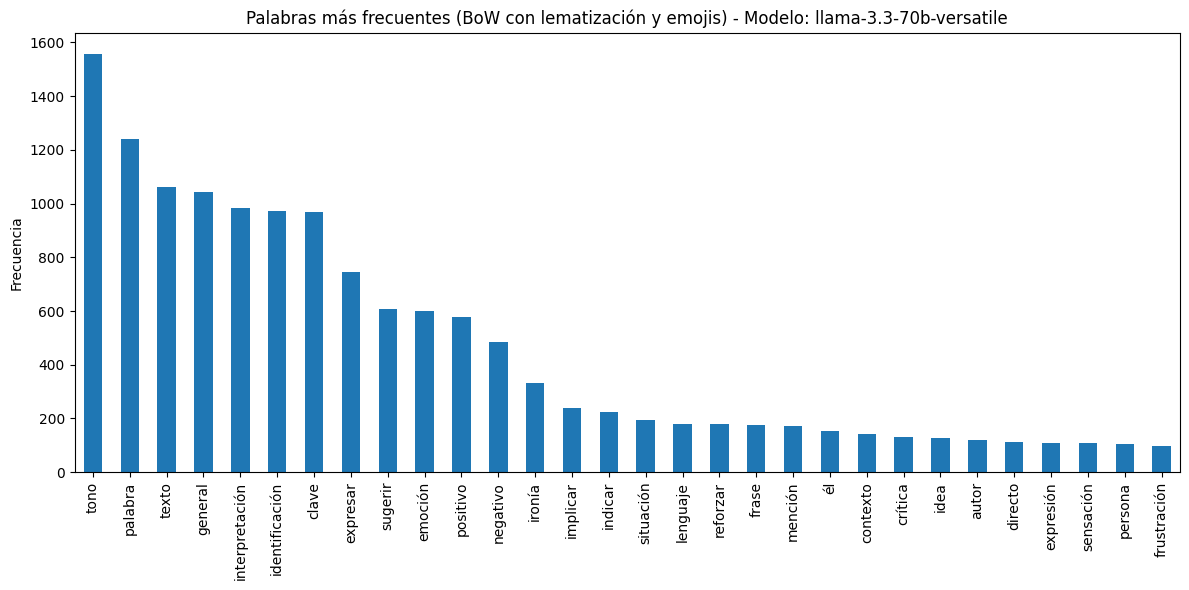

In [46]:
frecuencias = df_bow.sum().sort_values(ascending=False)

frecuencias.plot(
    kind='bar',
    figsize=(12,6),
    title=f"Palabras más frecuentes (BoW con lematización y emojis) - Modelo: {modelo[2]}"
)
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


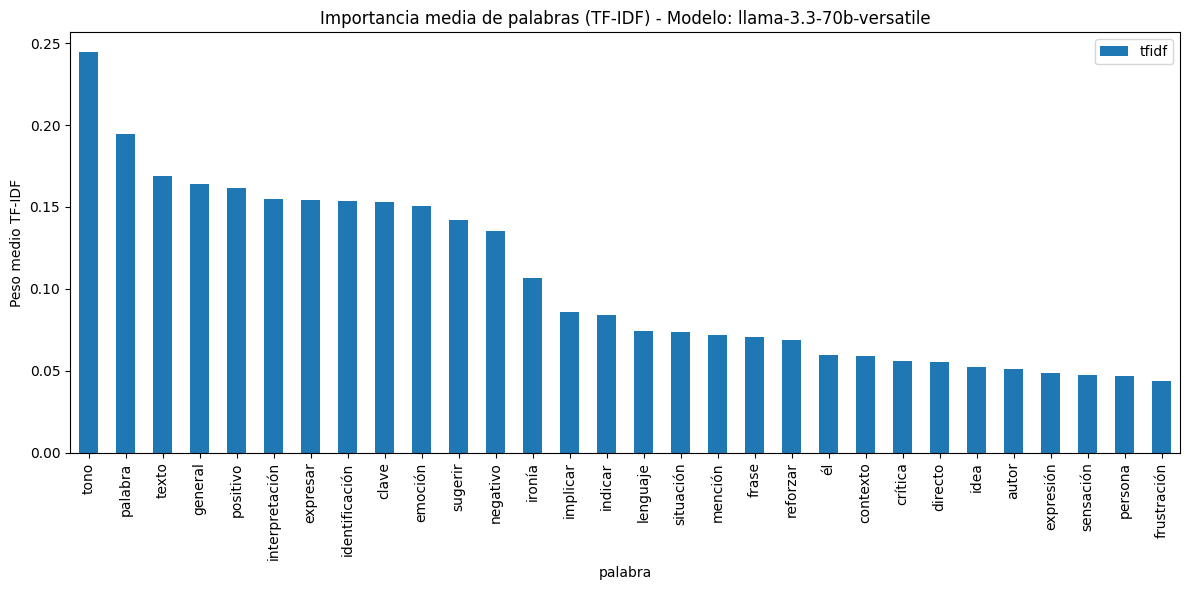

In [47]:
promedios = np.asarray(Xtfidf.mean(axis=0)).flatten()
palabras = vectorizer_tfidf.get_feature_names_out()

df_tfidf_prom = pd.DataFrame({"palabra": palabras, "tfidf": promedios})
df_tfidf_prom = df_tfidf_prom.sort_values(by="tfidf", ascending=False)

df_tfidf_prom.plot.bar(x="palabra", y="tfidf", figsize=(12,6), title=f"Importancia media de palabras (TF-IDF) - Modelo: {modelo[2]}")
plt.ylabel("Peso medio TF-IDF")
plt.tight_layout()
plt.show()

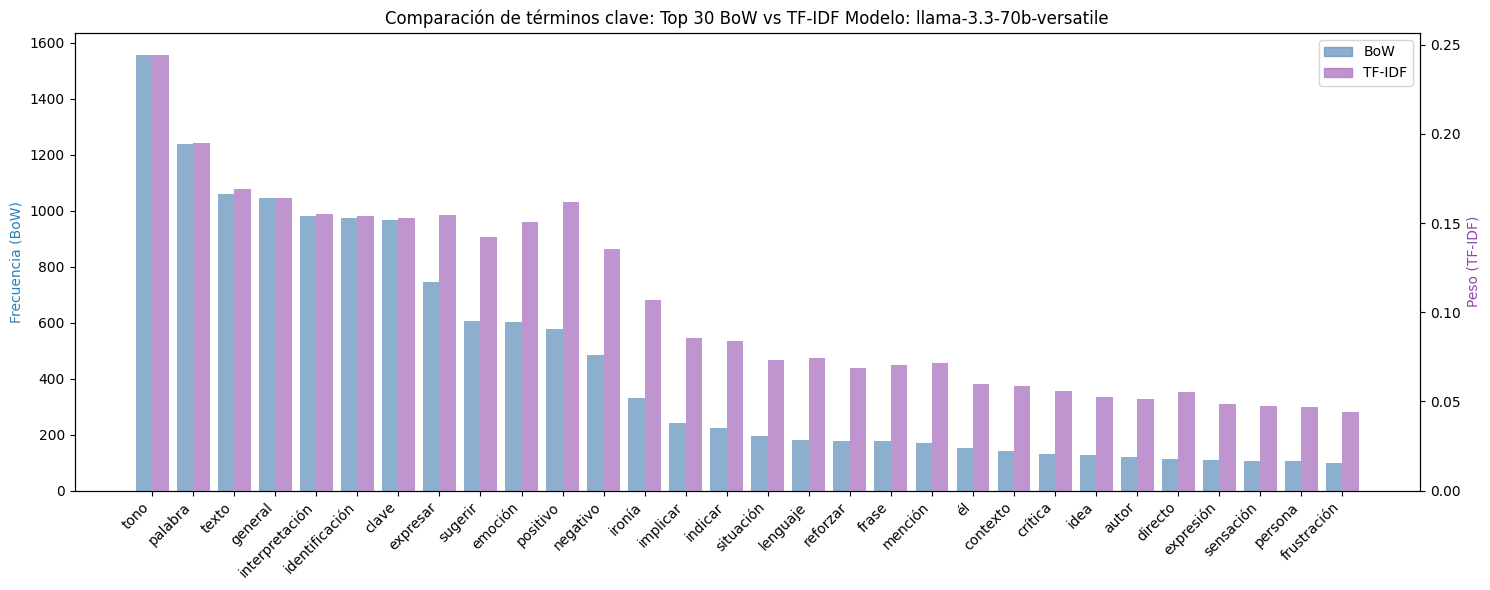

In [48]:
palabras_top20 = frecuencias.head(30).index.tolist()
frecuencias_bow = frecuencias.head(30).values
pesos_tfidf = df_tfidf_prom.set_index("palabra").loc[palabras_top20, "tfidf"].values

x = np.arange(len(palabras_top20))
width = 0.4

fig, ax1 = plt.subplots(figsize=(15, 6))
bars1 = ax1.bar(
    x - width/2, frecuencias_bow, width, 
    label='BoW', color='#5B8DB8', alpha=0.7  # azul más opaco
)
ax1.set_ylabel('Frecuencia (BoW)', color='#2980b9')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(palabras_top20, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2, pesos_tfidf, width, 
    label='TF-IDF', color='#A569BD', alpha=0.7  # morado más opaco
)
ax2.set_ylabel('Peso (TF-IDF)', color='#8e44ad')
ax2.tick_params(axis='y', labelcolor='black')

# Crear leyenda combinada
handles = [
    plt.Rectangle((0,0),1,1, color='#5B8DB8', alpha=0.7, label='BoW'),
    plt.Rectangle((0,0),1,1, color='#A569BD', alpha=0.7, label='TF-IDF')
]
ax1.legend(handles=handles, loc='upper right')

plt.title(f'Comparación de términos clave: Top 30 BoW vs TF-IDF Modelo: {modelo[2]}')
plt.tight_layout()
plt.show()


In [49]:
colores = ["#FF6666", "#B0B0B0", "#66FF66"]
df_tfidf_polar.T.plot(kind="bar", figsize=(15,), color=colores, alpha=0.8)
plt.title(f"Importancia de palabras por polaridad resultante de CoT (TF-IDF) - Modelo: {modelo[2]}")
plt.xlabel("Palabras")
plt.ylabel("Peso TF-IDF")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

TypeError: Bbox.from_bounds() missing 1 required positional argument: 'height'

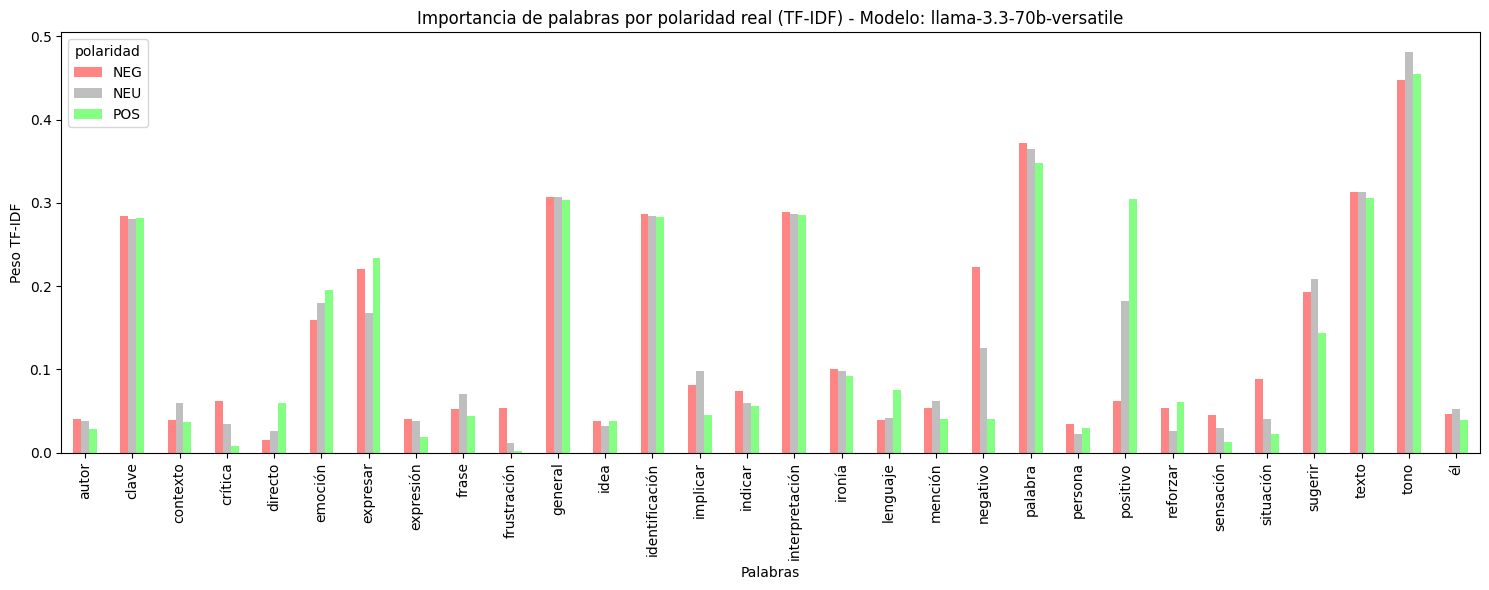

In [ ]:
colores = ["#FF6666", "#B0B0B0", "#66FF66"]
df_tfidf_polar_true.T.plot(kind="bar", figsize=(15,6), color=colores, alpha=0.8)
plt.title(f"Importancia de palabras por polaridad real (TF-IDF) - Modelo: {modelo[2]}")
plt.xlabel("Palabras")
plt.ylabel("Peso TF-IDF")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

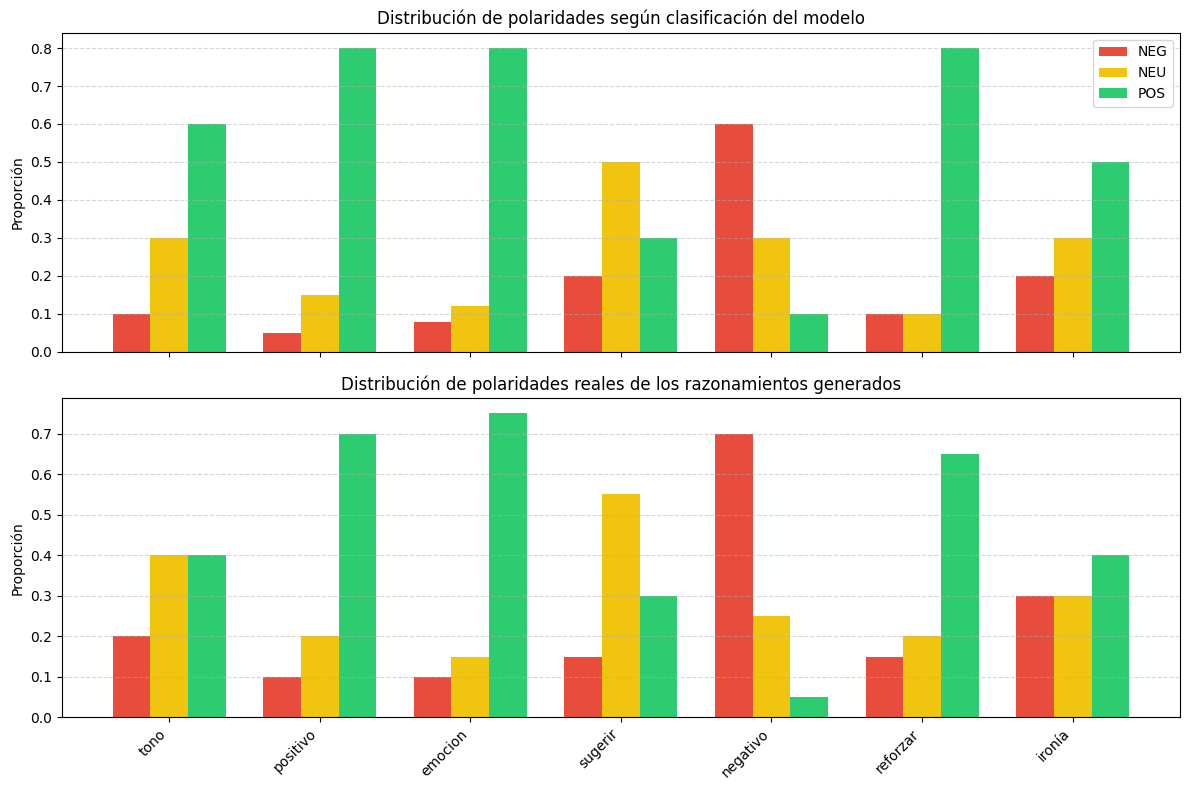

In [ ]:
# Lista de palabras clave (puedes reemplazar por tus datos)
palabras = ['tono', 'positivo', 'emocion', 'sugerir', 'negativo', 'reforzar', 'ironía']

# Valores de distribución por palabra: [NEG, NEU, POS]
# Sustituye estas listas por los valores reales
predicha = [
    [0.1, 0.3, 0.6],
    [0.05, 0.15, 0.8],
    [0.08, 0.12, 0.8],
    [0.2, 0.5, 0.3],
    [0.6, 0.3, 0.1],
    [0.1, 0.1, 0.8],
    [0.2, 0.3, 0.5]
]

real = [
    [0.2, 0.4, 0.4],
    [0.1, 0.2, 0.7],
    [0.1, 0.15, 0.75],
    [0.15, 0.55, 0.3],
    [0.7, 0.25, 0.05],
    [0.15, 0.2, 0.65],
    [0.3, 0.3, 0.4]
]

# Posiciones y configuración
x = np.arange(len(palabras))
width = 0.25
colors = ['#e74c3c', '#f1c40f', '#2ecc71']  # NEG (rojo), NEU (amarillo), POS (verde)
labels = ['NEG', 'NEU', 'POS']

# Crear figura con dos subgráficas
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Gráfico 1: Polaridad predicha
for i in range(3):
    axs[0].bar(x + (i - 1) * width, [p[i] for p in predicha], width,
               label=labels[i], color=colors[i])
axs[0].set_title('Distribución de polaridades según clasificación del modelo')
axs[0].set_ylabel('Proporción')
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.5)

# Gráfico 2: Polaridad real
for i in range(3):
    axs[1].bar(x + (i - 1) * width, [r[i] for r in real], width,
               label=labels[i], color=colors[i])
axs[1].set_title('Distribución de polaridades reales de los razonamientos generados')
axs[1].set_ylabel('Proporción')
axs[1].set_xticks(x)
axs[1].set_xticklabels(palabras, rotation=45, ha='right')
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

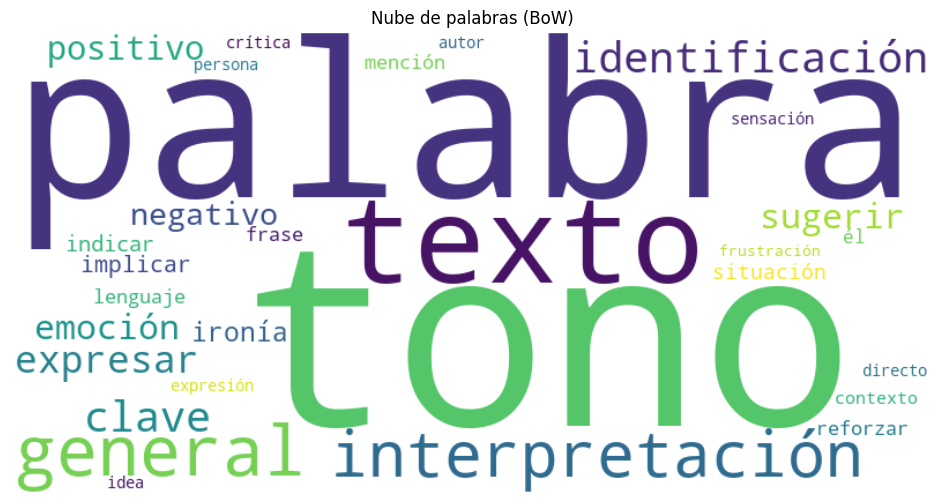

In [ ]:
frecuencias_dict = df_bow.sum().to_dict() # sumar frecuencias por palabra
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frecuencias_dict) #Generacion de nube de palabras

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras (BoW)")
plt.show()

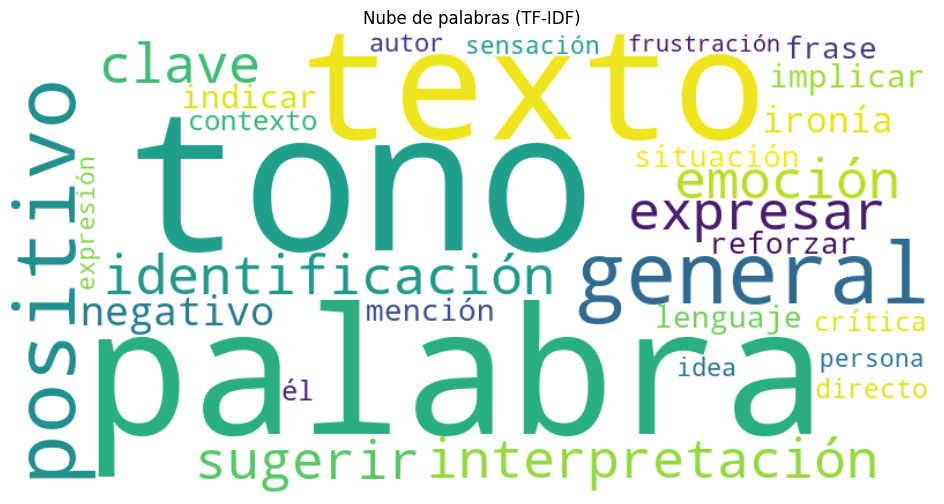

In [ ]:
frecuencias_dict = dict(zip(df_tfidf_prom["palabra"], df_tfidf_prom["tfidf"]))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frecuencias_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras (TF-IDF)")
plt.show()

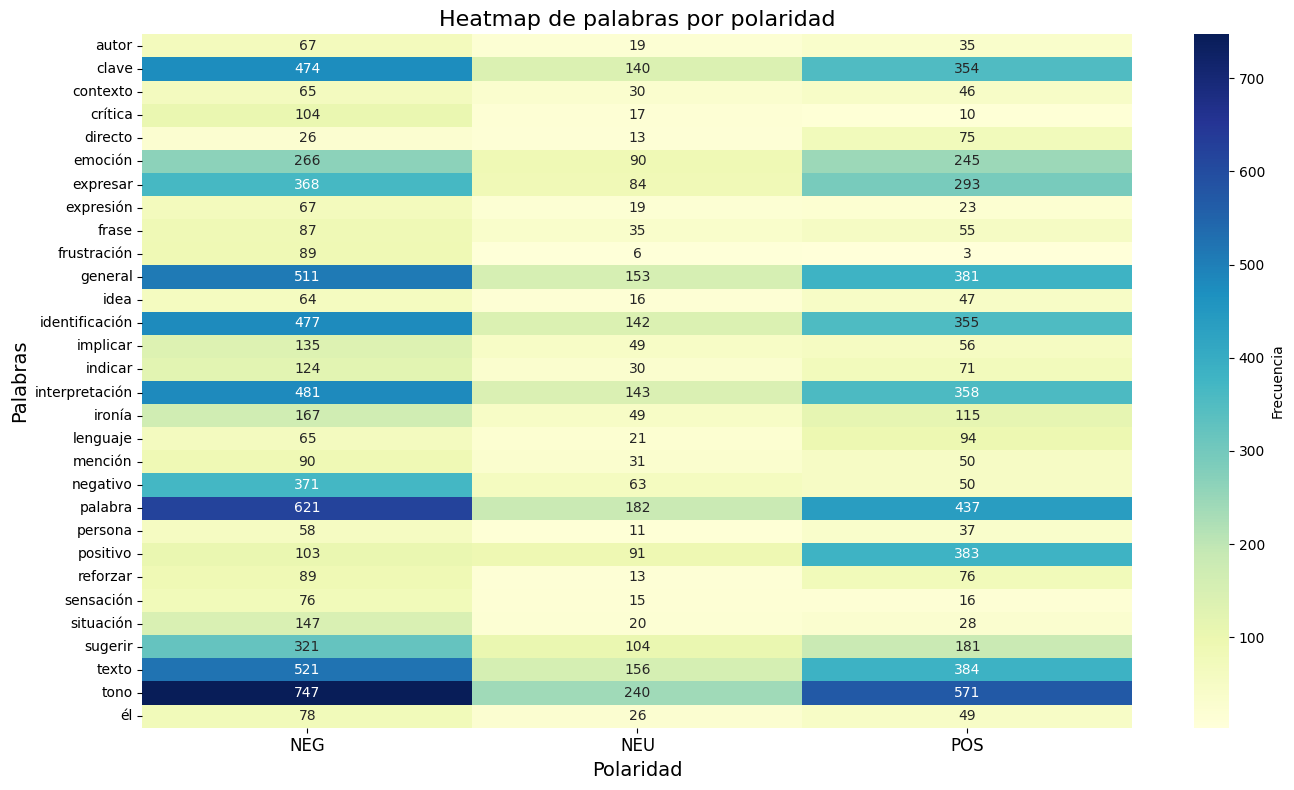

In [ ]:
df_bow['Etiqueta'] = df['Polarity']
bow_por_clase = df_bow.groupby('Etiqueta').sum()

plt.figure(figsize=(14, 8))
sns.heatmap(bow_por_clase.T, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frecuencia'})
plt.title("Heatmap de palabras por polaridad", fontsize=16)
plt.xlabel("Polaridad", fontsize=14)
plt.ylabel("Palabras", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

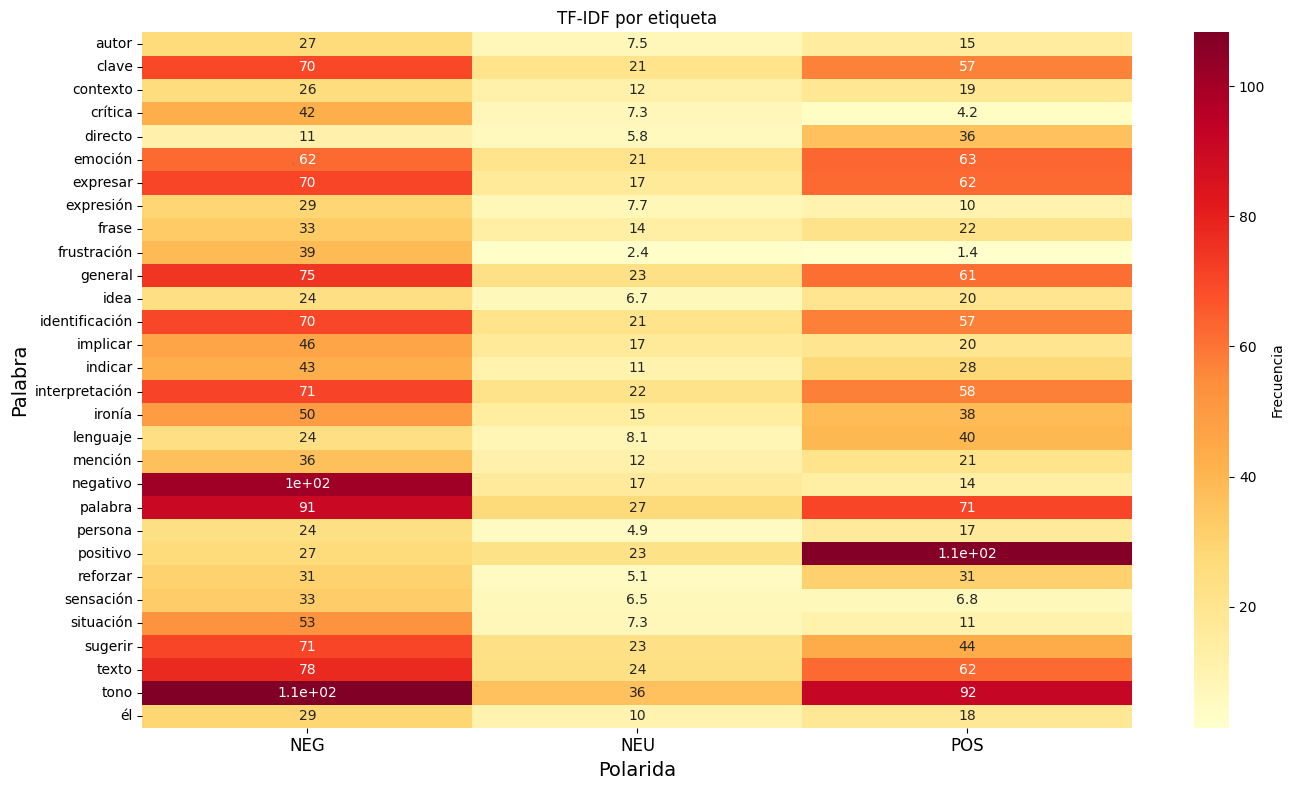

In [ ]:
df_tfidf["Etiqueta"] = df["Polarity"]
tfidf_por_etiqueta = df_tfidf.groupby("Etiqueta").sum()

plt.figure(figsize=(14, 8))
sns.heatmap(tfidf_por_etiqueta.T, cmap="YlOrRd", annot=True, cbar_kws={'label': 'Frecuencia'})
plt.title("TF-IDF por etiqueta")
plt.xlabel("Polarida", fontsize=14)
plt.ylabel("Palabra", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()


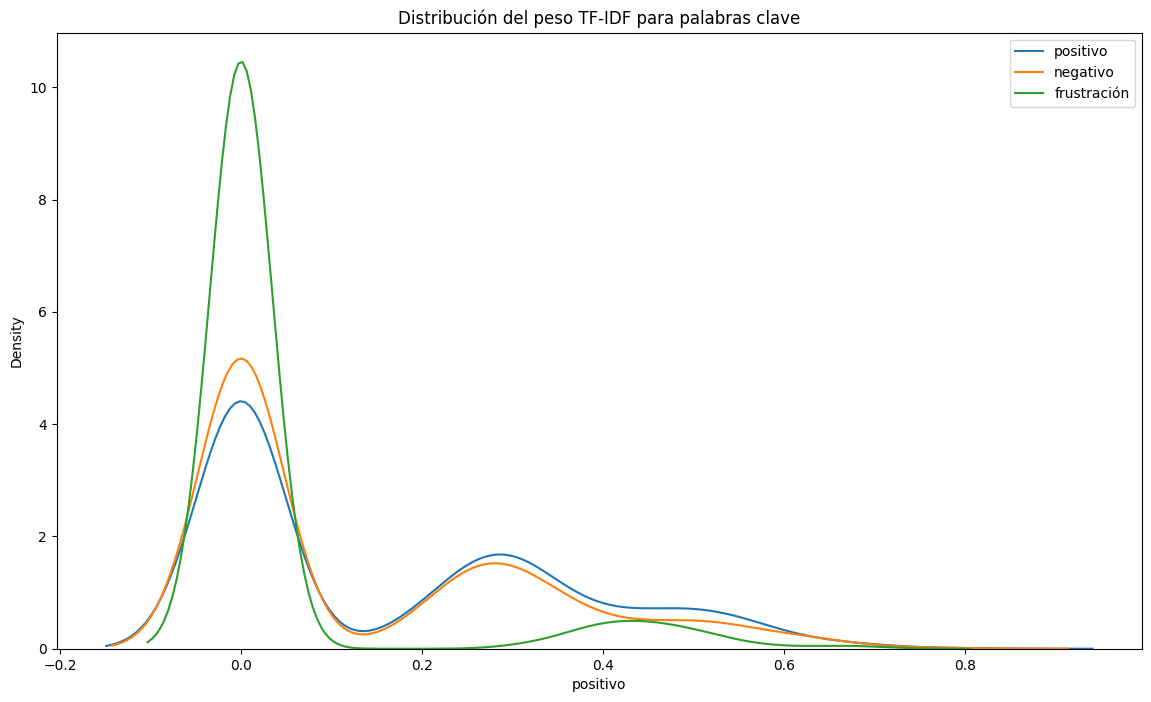

In [ ]:
plt.figure(figsize=(14, 8))
palabras_clave = ["positivo", "negativo", "neutral", "alegria", "tristeza", "ironia", "preocupacion", "miedo", "desprecio", "confianza", "satisfacción", "frustración", "entusiasmo", "emocional"]
for palabra in palabras_clave:
    if palabra in df_tfidf.columns:
        sns.kdeplot(df_tfidf[palabra], label=palabra)

plt.title("Distribución del peso TF-IDF para palabras clave")
plt.legend()
plt.show()

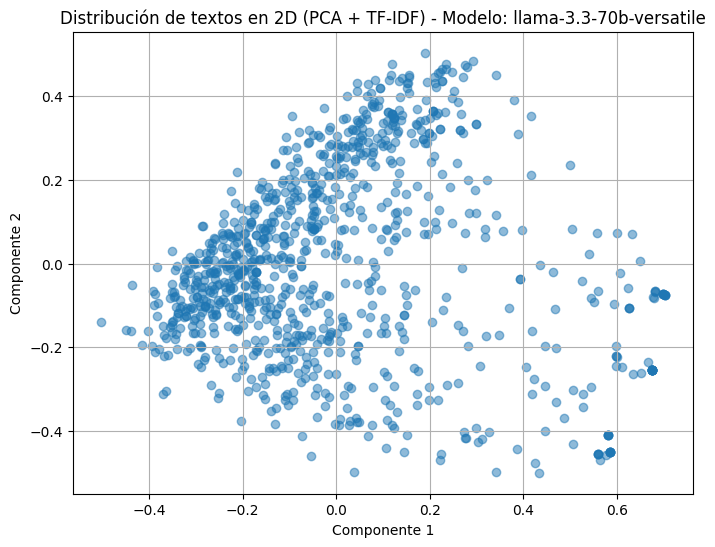

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xtfidf.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title(f"Distribución de textos en 2D (PCA + TF-IDF) - Modelo: {modelo[2]}")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

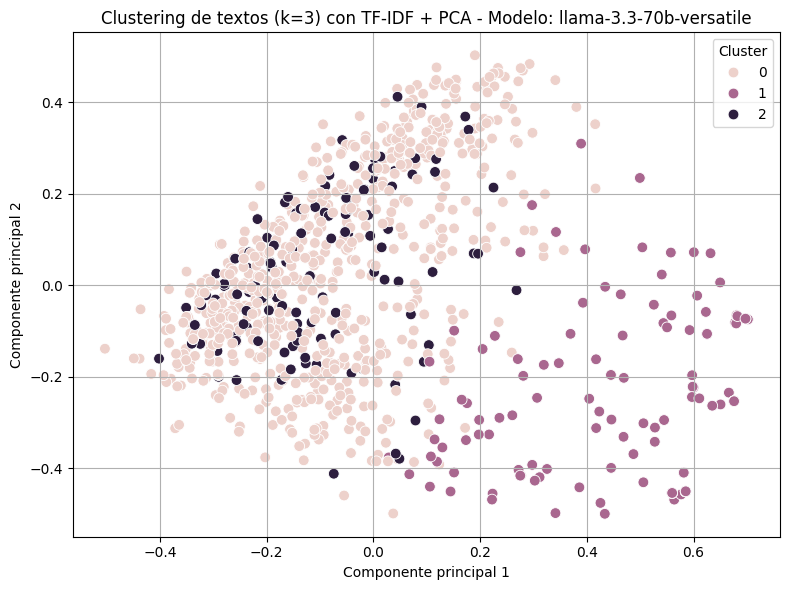

In [69]:
k = 3  #numero clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Xtfidf)
X_pca = pca.fit_transform(Xtfidf.toarray())

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, s=60)
plt.title(f"Clustering de textos (k={k}) con TF-IDF + PCA - Modelo: {modelo[2]}")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df["Cluster"] = kmeans.labels_

for i in range(k):
    print(f" Ejemplos del Cluster {i}:")
    ejemplos = df[df["Cluster"] == i]["Raw_llama-3.3-70b-versatile_Chain_Of_Thought"].head(3)  # Ajusta el nombre de la columna si es necesario
    for ej in ejemplos:
        print("•", ej[:120] + "...")

 Ejemplos del Cluster 0:
• 1. Identificación de palabras clave: "Quiero mogollón", "sobretodo", "lo rápido que contesta"
2. Interpretación del tono...
• 1. Identificación de palabras clave: "mucho más", "Me habías entendido mal"
2. Interpretación del tono general: El texto...
• 1. Identificación de palabras clave: "basura", "evolucionar para bien"
2. Interpretación del tono general: El texto expr...
 Ejemplos del Cluster 1:
• 1. Identificación de palabras clave: "pinta buena", "gracias"
2. Interpretación del tono general: El texto expresa una i...
• 1. Identificación de palabras clave: "lapsus advertido", "subsanado", "Gracias"
2. Interpretación del tono general: El t...
• 1. Identificación de palabras clave: "gente muy buena", "trabajando duro", "palabras así impulsan"
2. Interpretación del...
 Ejemplos del Cluster 2:
• 1. Identificación de palabras clave: "puto mal", "sigo surrando", "ha quedado raro", "JAJAJAJA"
2. Interpretación del to...
• 1. Identificación de palabras clave: "Val

In [ ]:
df_tfidf_con_cluster = pd.DataFrame(Xtfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf_con_cluster["cluster"] = clusters

for i in range(3):
    print(f"Palabras más representativas del Cluster {i}")
    cluster_i = df_tfidf_con_cluster[df_tfidf_con_cluster["cluster"] == i].drop("cluster", axis=1)
    print(cluster_i.mean().sort_values(ascending=False).head(7))

Palabras más representativas del Cluster 0
tono              0.253169
palabra           0.205661
texto             0.170563
general           0.168865
expresar          0.159917
interpretación    0.159270
identificación    0.157306
dtype: float64
Palabras más representativas del Cluster 1
lenguaje    0.423352
directo     0.354460
ironía      0.258132
emoción     0.238807
tono        0.224453
positivo    0.201825
texto       0.169530
dtype: float64
Palabras más representativas del Cluster 2
él          0.476734
tono        0.214417
palabra     0.165201
texto       0.159082
sugerir     0.147672
general     0.146920
positivo    0.145124
dtype: float64


Distribución polaridad por cluster:
Polaridad  NEG  NEU  POS
Cluster                 
0          313  108  293
1           25   25   87
2           44   25   48
              precision    recall  f1-score   support

         NEG       0.38      0.12      0.18       382
         NEU       0.15      0.68      0.25       158
         POS       0.64      0.20      0.31       428

    accuracy                           0.25       968
   macro avg       0.39      0.33      0.24       968
weighted avg       0.45      0.25      0.25       968



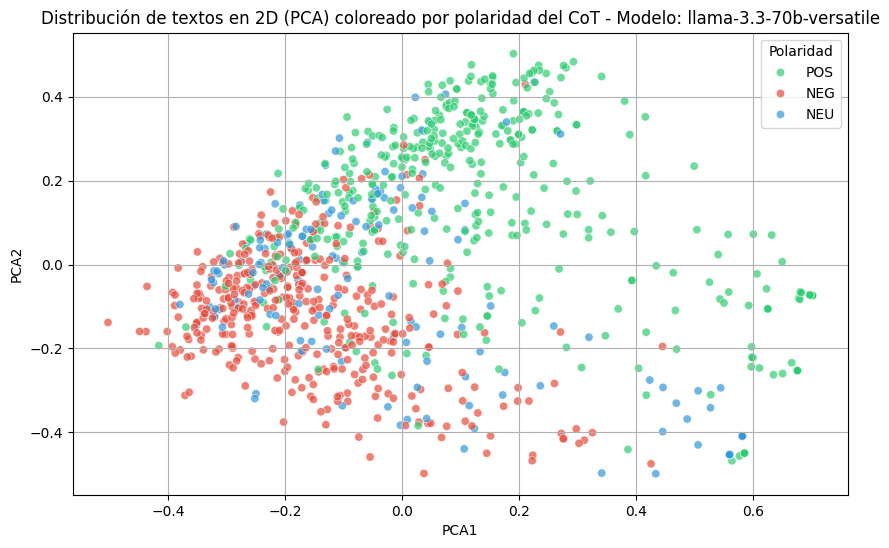

In [72]:
df_clusters = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters,
    "Polaridad": polaridad  # del chain of thought
})

print("Distribución polaridad por cluster:")
print(pd.crosstab(df_clusters["Cluster"], df_clusters["Polaridad"]))


mapa_cluster_polaridad = {   #Visto a ojo en los clusters generados
    0: "NEU",  
    1: "POS",
    2: "NEG"
}
df_clusters["Polaridad_predicha"] = df_clusters["Cluster"].map(mapa_cluster_polaridad)

print(classification_report(df_clusters["Polaridad"], df_clusters["Polaridad_predicha"]))

paleta = {
    "POS": "#2ecc71",  
    "NEG": "#e74c3c", 
    "NEU": "#3498db"  
}
plt.figure(figsize=(10,6))
plt.grid(True)
sns.scatterplot(data=df_clusters, x="PCA1", y="PCA2", hue="Polaridad", palette=paleta, alpha=0.7)
plt.title(f"Distribución de textos en 2D (PCA) coloreado por polaridad del CoT - Modelo: {modelo[2]}")
plt.legend(title="Polaridad")
plt.show()



Distribución polaridad por cluster:
Polaridad  NEG  NEU  POS
Cluster                 
0          379  103  232
1           34   15   88
2           61   22   34
              precision    recall  f1-score   support

         NEG       0.53      0.80      0.64       474
         NEU       0.11      0.11      0.11       140
         POS       0.29      0.10      0.14       354

    accuracy                           0.44       968
   macro avg       0.31      0.33      0.30       968
weighted avg       0.38      0.44      0.38       968



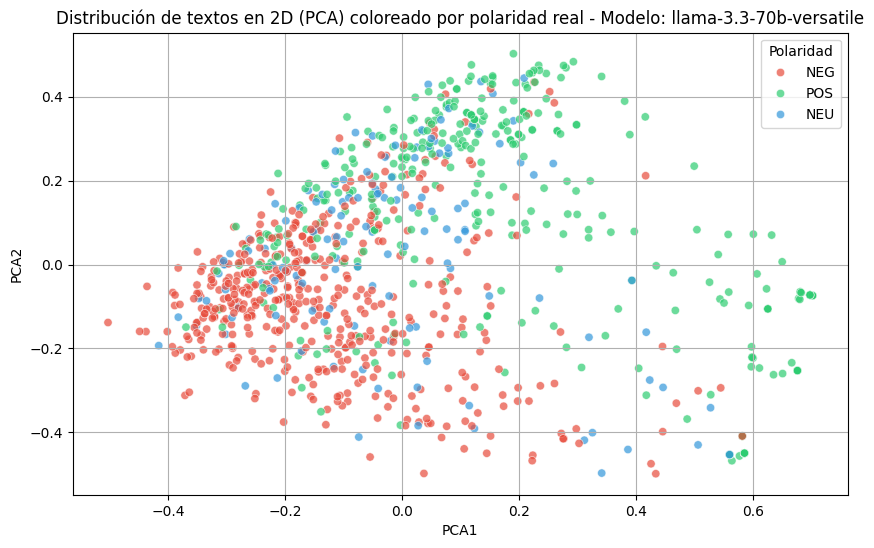

In [73]:
df_clusters = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters,
    "Polaridad": polaridad_True  # real
})

print("Distribución polaridad por cluster:")
print(pd.crosstab(df_clusters["Cluster"], df_clusters["Polaridad"]))


mapa_cluster_polaridad = {   #Visto a ojo en los clusters generados
    0: "NEG",  
    1: "NEU",
    2: "POS"
}
df_clusters["Polaridad_predicha"] = df_clusters["Cluster"].map(mapa_cluster_polaridad)

print(classification_report(df_clusters["Polaridad"], df_clusters["Polaridad_predicha"]))

paleta = {
    "POS": "#2ecc71",  
    "NEG": "#e74c3c", 
    "NEU": "#3498db"  
}
plt.figure(figsize=(10,6))
plt.grid(True)
sns.scatterplot(data=df_clusters, x="PCA1", y="PCA2", hue="Polaridad", palette=paleta, alpha=0.7)
plt.title(f"Distribución de textos en 2D (PCA) coloreado por polaridad real - Modelo: {modelo[2]}")
plt.legend(title="Polaridad")
plt.show()